<a href="https://colab.research.google.com/github/XTMay/VibeCoding_ClaudeCode/blob/main/lesson-01-intro/AI_Workflow_%26_AI_Agent%EF%BC%9A%E6%9E%B6%E6%9E%84%E3%80%81%E6%A8%A1%E5%BC%8F%E4%B8%8E%E5%B7%A5%E7%A8%8B%E5%BB%BA%E8%AE%AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Workflow & AI Agent：架构、模式与工程建议



> **Agents 只是一些“在一个循环中，基于环境反馈来选择合适的工具，最终完成其任务”的大模型。**



[Building effective agents](https://www.anthropic.com/engineering/building-effective-agents)

## **1 什么是 AI Agent/Workflow？**

目前关于 AI Agent 并**没有一个统一的定义**：

- 有人将 Agent 定义为**完全自主的系统**，这些系统可以在**较长时间内独立运行**，使用各种**工具**来完成复杂任务。
- 有人则用这个术语来描述一种遵循**预定义工作流的规范**实现（prescriptive implementations that follow predefined workflows）。

在 Anthropic，将所有这些统一归类为 **agentic systems**。

### 1.1 Workflow vs. Agent

虽然统一称为“**智能体系统**”，但我们还是对 Workflow 和 Agent 做出了重要的架构区分， 因此二者属于两类不同的系统：

- **Workflow**：通过**预定义**的代码路径来编排大模型和和工具 （systems where LLMs and tools are orchestrated through predefined code paths）；
- **Agent**：大模型动态决定自己的流程及使用什么工具，**自主控制**如何完成任务 （systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks）。

### 1.2 何时使用/不使用 Agent & Workflow

在使用大模型构建应用程序时，我们建议寻找尽可能**简单**的方案，只有在必要时才增加复杂性。


> 这意味着如无必要，不要试图构建 Agent/Workflow。


Agent/Workflow 虽然在处理任务时效果更好，但通常也会有**更高的延迟和成本**，因此需要权衡利弊。



> 如果确实是要解决复杂场景的问题，

Workflow 为明确定义的任务提供了**可预测性和一致性**，Agent 则在需要**大规模灵活性和模型驱动的决策**时是一个更好的选择。

但是，对于很多应用程序来说，**大模型 LLM**本身加上 **RAG、in-context examples** 等技术通常就足以解决问题了。

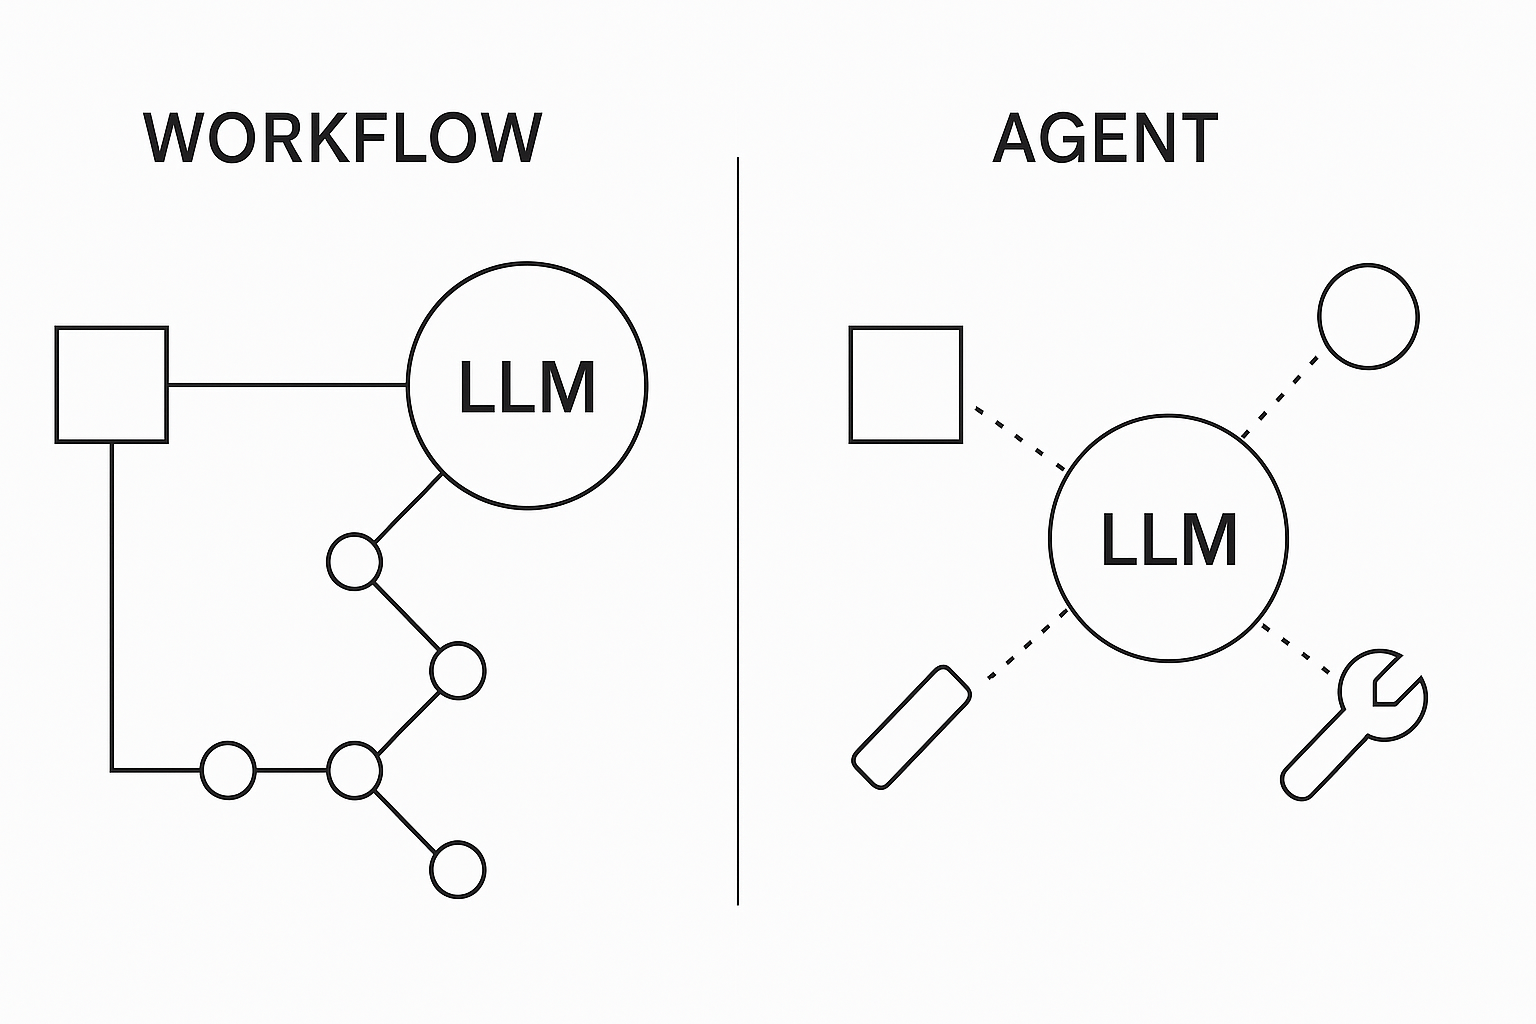

### 1.3 何时以及如何使用框架

许多框架可以简化 Agent/Workflow 的实现，包括：

- LangGraph from LangChain;
- Amazon Bedrock’s AI Agent framework;
- Rivet, a drag and drop GUI LLM workflow builder; and
- Vellum, another GUI tool for building and testing complex workflows.
- n8n

这些框架通过简化标准的底层任务（如调用 LLM、定义和解析工具以及链接调用）使用户更容易入门。
但是，它们通常会创建额外的抽象层，这可能会使底层的提示和响应变得难以调试，**增加了不必要的复杂性**。

我们建议开发者，首选直接使用 **LLM API**：
本文接下来介绍的许多模式几行代码就能实现；

如果确实要用框架，要确保理解这些框架的底层代码。对底层代码的错误假设是常见的问题来源。

In [ ]:
from util import llm_call, extract_xml

def generate(prompt: str, task: str, context: str = "") -> tuple[str, str]:
    """Generate and improve a solution based on feedback."""
    full_prompt = f"{prompt}\n{context}\nTask: {task}" if context else f"{prompt}\nTask: {task}"
    response = llm_call(full_prompt)
    thoughts = extract_xml(response, "thoughts")
    result = extract_xml(response, "response")

    print("\n=== GENERATION START ===")
    print(f"Thoughts:\n{thoughts}\n")
    print(f"Generated:\n{result}")
    print("=== GENERATION END ===\n")

    return thoughts, result

In [ ]:
def evaluate(prompt: str, content: str, task: str) -> tuple[str, str]:
    """Evaluate if a solution meets requirements."""
    full_prompt = f"{prompt}\nOriginal task: {task}\nContent to evaluate: {content}"
    response = llm_call(full_prompt)
    evaluation = extract_xml(response, "evaluation")
    feedback = extract_xml(response, "feedback")

    print("=== EVALUATION START ===")
    print(f"Status: {evaluation}")
    print(f"Feedback: {feedback}")
    print("=== EVALUATION END ===\n")

    return evaluation, feedback

In [ ]:

def loop(task: str, evaluator_prompt: str, generator_prompt: str) -> tuple[str, list[dict]]:
    """Keep generating and evaluating until requirements are met."""
    memory = []
    chain_of_thought = []

    thoughts, result = generate(generator_prompt, task)
    memory.append(result)
    chain_of_thought.append({"thoughts": thoughts, "result": result})

    while True:
        evaluation, feedback = evaluate(evaluator_prompt, result, task)
        if evaluation == "PASS":
            return result, chain_of_thought

        context = "\n".join([
            "Previous attempts:",
            *[f"- {m}" for m in memory],
            f"\nFeedback: {feedback}"
        ])

        thoughts, result = generate(generator_prompt, task, context)
        memory.append(result)
        chain_of_thought.append({"thoughts": thoughts, "result": result})
Example Use Case: Iterative

## **2 Workflow & Agent 的基础构建模块**


### 2.1 增强型大模型（augmented LLM）

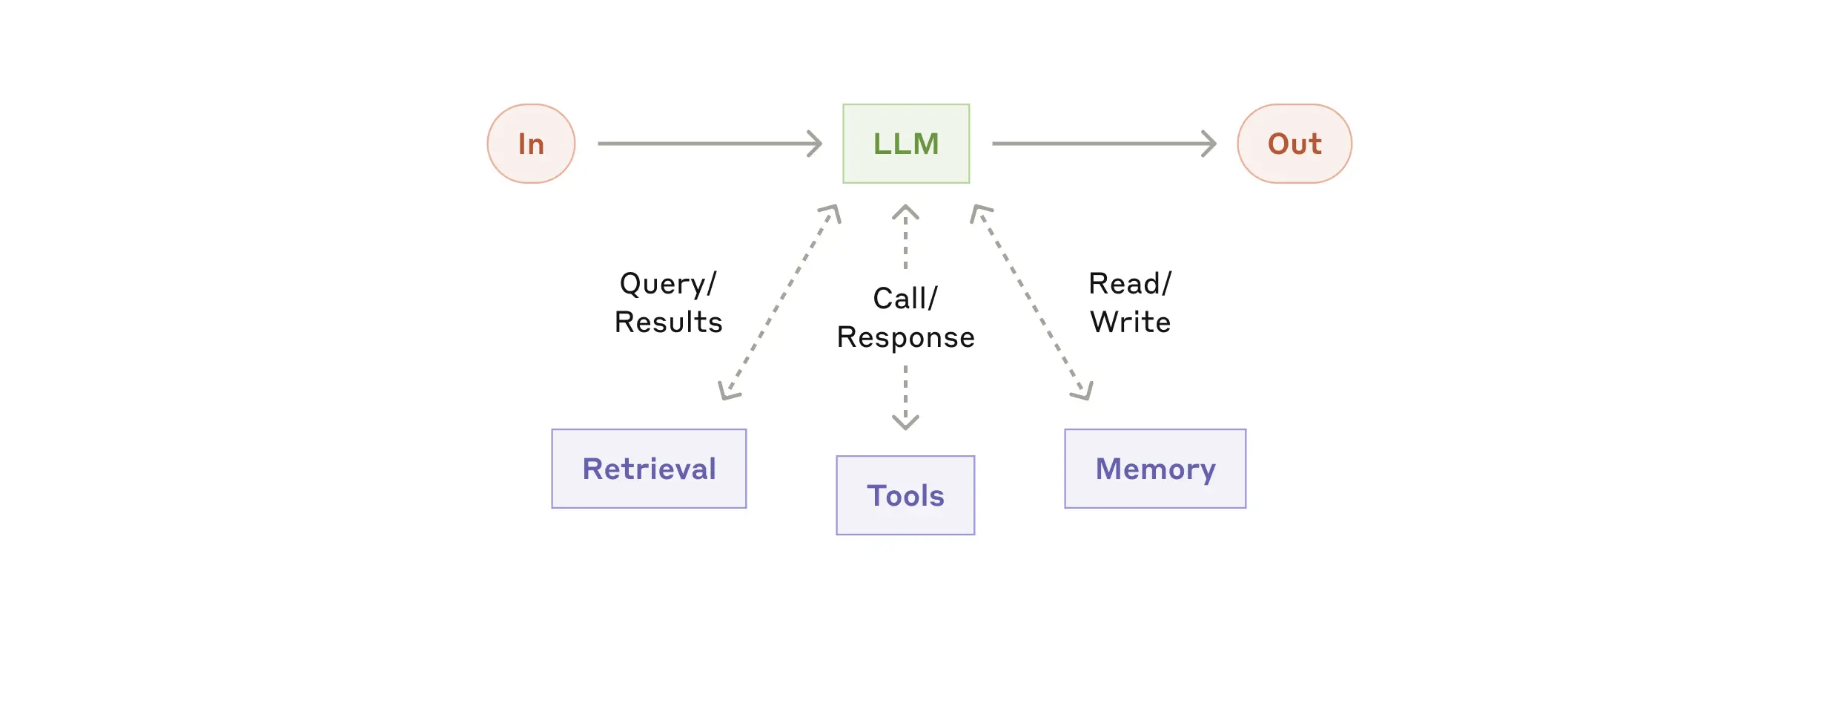

这个模型具有**检索、工具和记忆**等增强功能。 模型可以主动使用这些功能，例如搜索查询、选择适当的工具、保存必要的信息到记忆模块中等等

### 2.2 功能选型建议

关于以上提到的增强功能如何选择，我们有如下建议：

- 不是所有功能都需要用上，而应该根**据你的实际需求**，只保留最必要的部分；
- 尽量使用那些**文档完善的组件**，否则就是给自己挖坑。
- 最后，实现这些增强功能有**很多方式**，如最近发布的 Model Context Protocol （**MCP**）也是其中一种。 开发者只需要实现简单的客户端 client implementation， 就能与不断增长的第三方工具生态系统进行集成。



> ### 小结： **基于增强型大模型，我们就可以构建出各种 AI Workflow & Agent。**



## 3 Workflow

### 3.1 提示链（Prompt chaining）

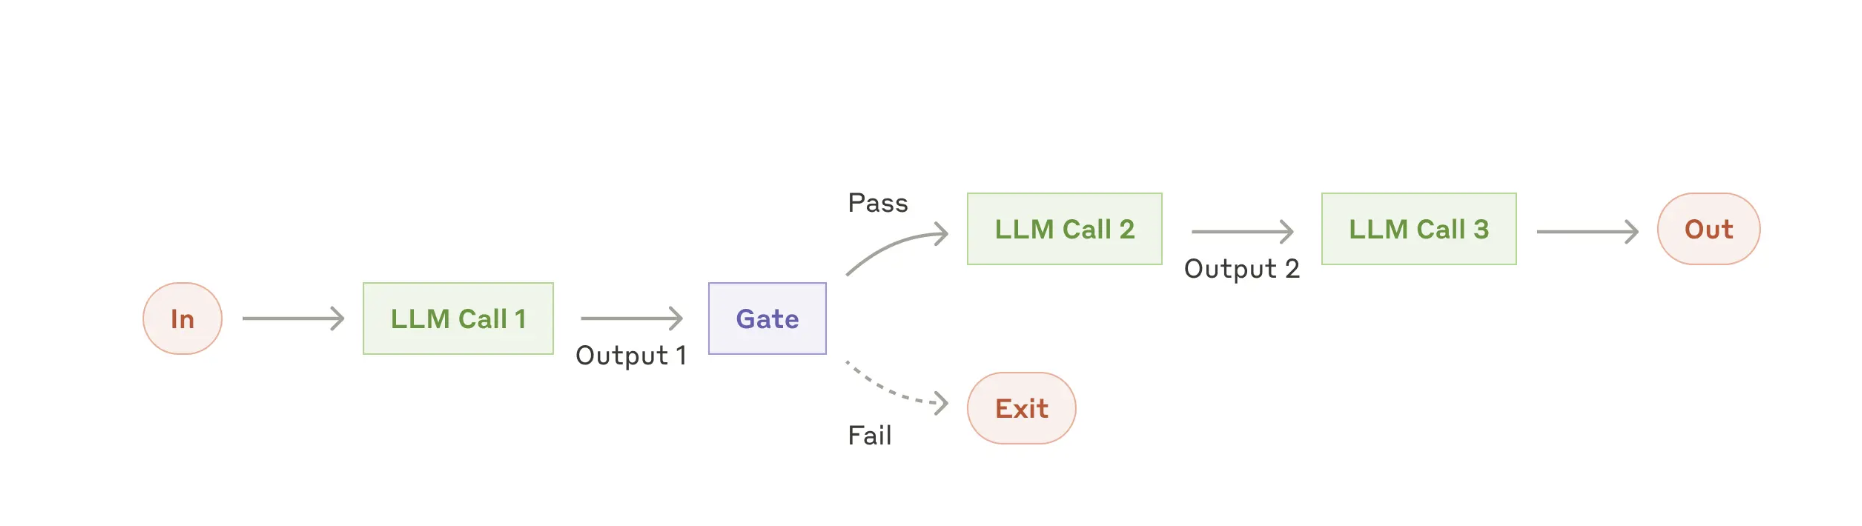

提示链将任务**分解为一系列顺序的子任务**，

**每个 LLM call 处理前一个 LLM call 的输出**；

可以在中间任何步骤添加检查点（图中的 “Gate”），以确保处理过程仍在正轨上

### 3.1.1 适用场景

适用于能干净地将任务分解为固定子任务的场景。



> 背后的逻辑：相比于一整个大任务，**拆解后的每个 LLM call 都是一个准确率更高、延迟更低、更容易完成的任务**。


### 3.1.2 场景举例

- 生成营销文案

生成营销文案，然后将其翻译成不同的语言。

- 按大纲编写文档

首先编写文档大纲，确保大纲符合某些标准，然后根据大纲编写文档。

## 3.2 路由（Routing）

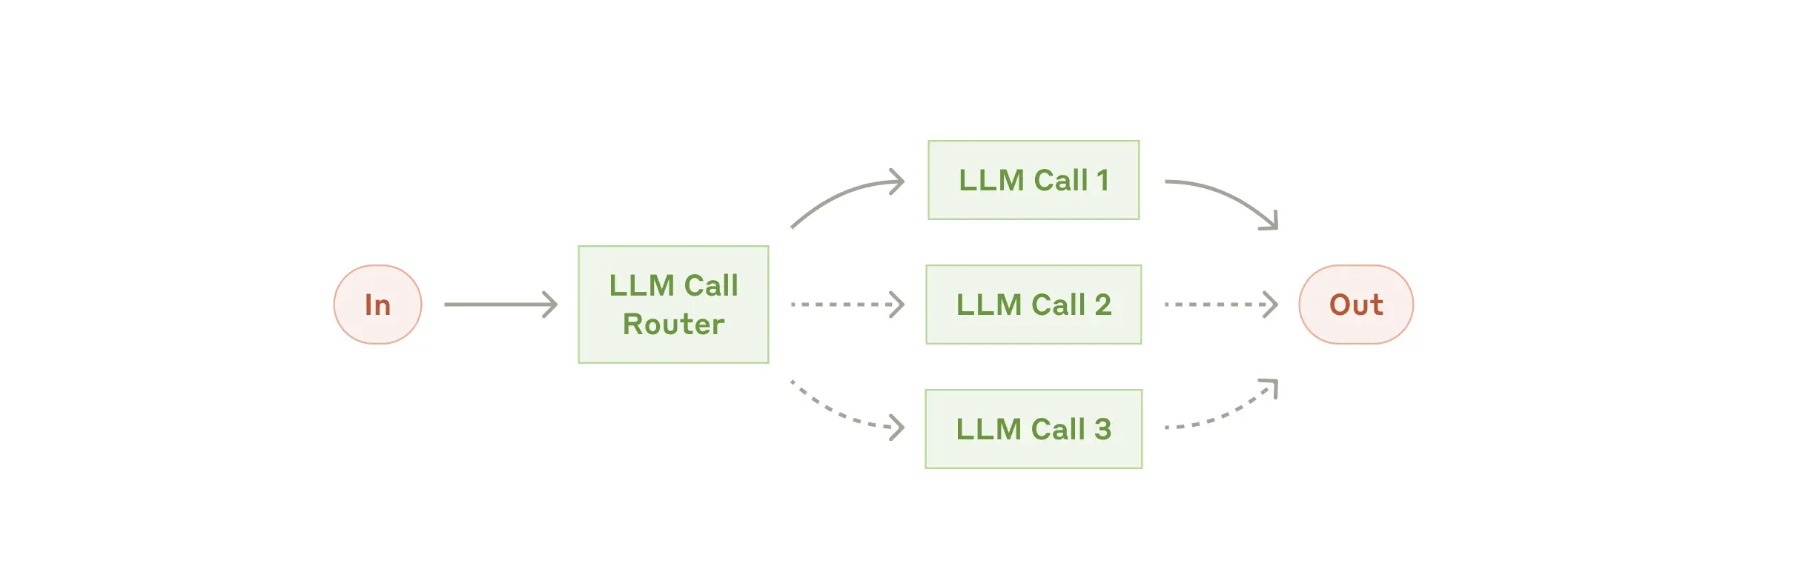

通过路由对**输入进行分类**，并将其**转发到专门的后续任务**（specialized followup task）。

将任务的关注点进行拆解，从而**针对每个具体任务设计和调整提示词**。

否则，（all-in-one）提示词不仅很长，而且针对任何一种任务的提示词优化都可能会导致其他任务的性能下降。

### 3.2.1 适用场景

适用于存在**不同类别的复杂任务**，而且这些类别分开处理时，都能得到更好的效果。

前提是**能够准确分类**，至于是使用大模型分类，还是使用传统模型/算法分类，关系不大。

### 3.2.2 场景举例
- 智能客服

将不同类型的用户问题（一般问题、请求退款、技术支持）转发到不同的下游流程、提示和工具。

- 大小模型路由

将简单/常见问题路由到较小的模型，如 Claude 3.5 Haiku，将困难/不寻常问题路由到更强大的模型，如 Claude 3.5 Sonnet，以优化成本和速度。

## 3.3 并行化（Parallelization）

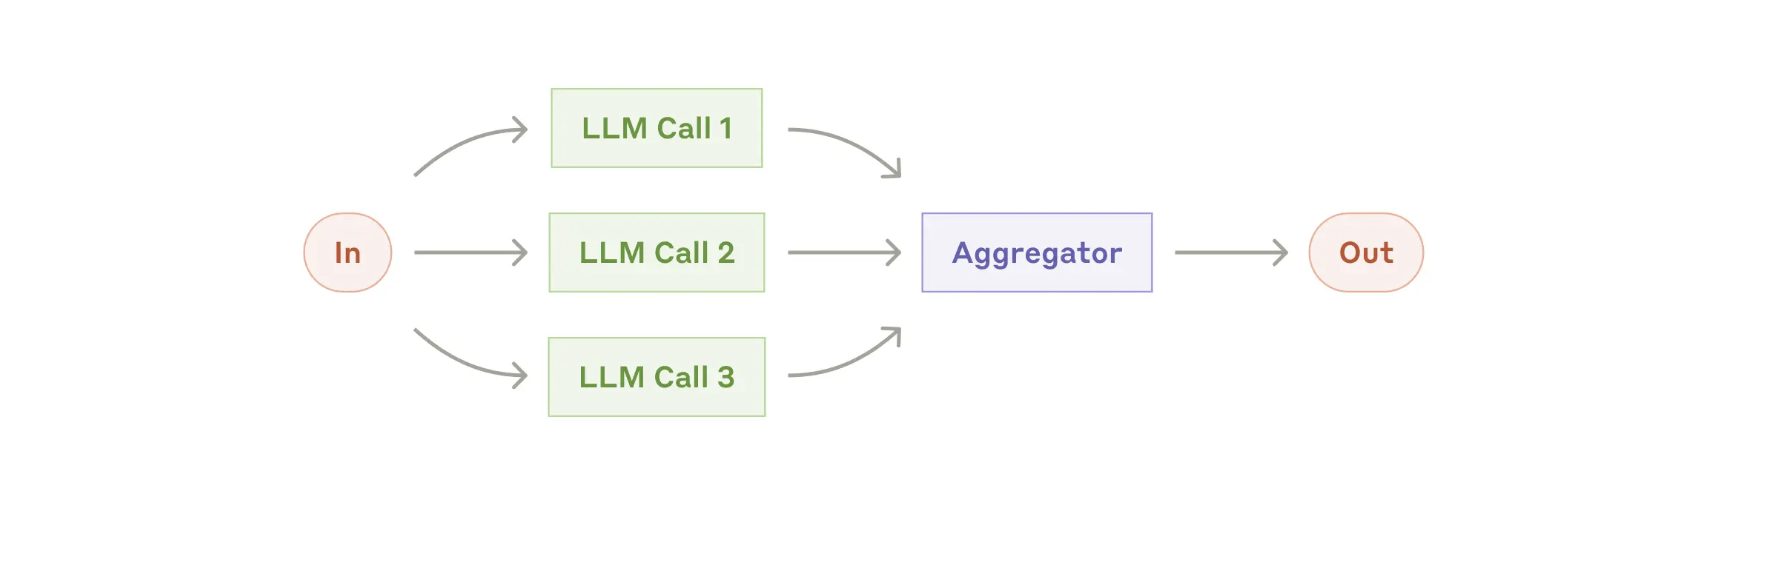

多个任务同时进行，然后对输出进行聚合处理。考虑两个场景：

- **分段（Sectioning）**：类似 MapReduce，将任务分解为独立的子任务并行运行，最后对输出进行**聚合**。
- **投票（Voting）**：相同的任务并行执行多次，以获得**多样化的输出**。

### 3.3.1 适用场景

分为两类：

- 并行化可以提高任务的最终完成速度，需要多种视角或尝试，**对所有结果进行对比，取最好的结果**。
- 背后的逻辑：如果一个复杂任务需要考虑很多方面，那针对每个方面单独调用 LLM 效果通常会更好， 因为**每个 LLM 都可以更好地关注一个具体方面**

### 3.3.2 场景举例

- **旁路安全检测**

属于 **Sectioning**

一个模型实例处理用户查询，另一个模型实例筛选是否包含不当的内容或请求。这通常比让同一个模型实例同时请求响应和安全防护效果更好。

- **大模型性能评估的自动化**

属于 **Sectioning**

针对给到的提示词，每个 LLM 调用评估模型不同方面的性能。

- **Code review**

属于 **voting**

几个不同的提示审查并标记代码，寻找漏洞。

- **生成的代码的质量评估**

属于 **voting**

评估输出的代码是否恰当：使用多个提示词，分别评估生成的代码的不同方面， 或通过不同的投票阈值，以平衡误报和漏报（false positives and negatives）。

## 3.4 编排者-工作者（Orchestrator-workers）

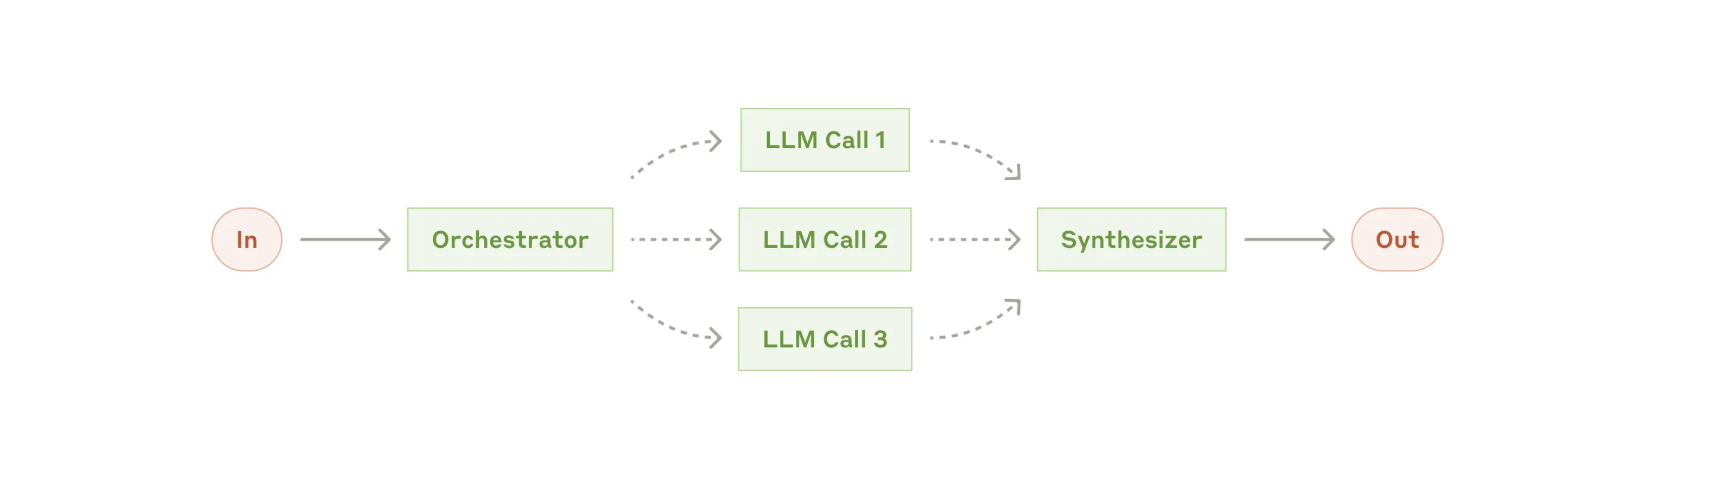



> 在这种 Workflow 中，一个**中心式 LLM** 动态地**分解**任务，将其**委托**给 **worker LLM**，并**汇总**它们的结果。





### 3.4.1 适用场景

适用于**无法预测所需子任务的复杂任务**。例如，在编程中，修改的文件数量。

虽然在拓扑上与 Parallelization Workflow 相似，但关键区别在于其灵活性 —— **子任务不是预先定义的，而是由协调者/编排者根据特定输入确定的**

### 3.4.2 场景举例

- **Code review**

编程产品：每次对多个文件（数量不确定）进行修改。

- **智能搜索**

搜索任务：从多个来源收集和分析信息。

## 3.5 评估者-优化者（Evaluator-optimizer）

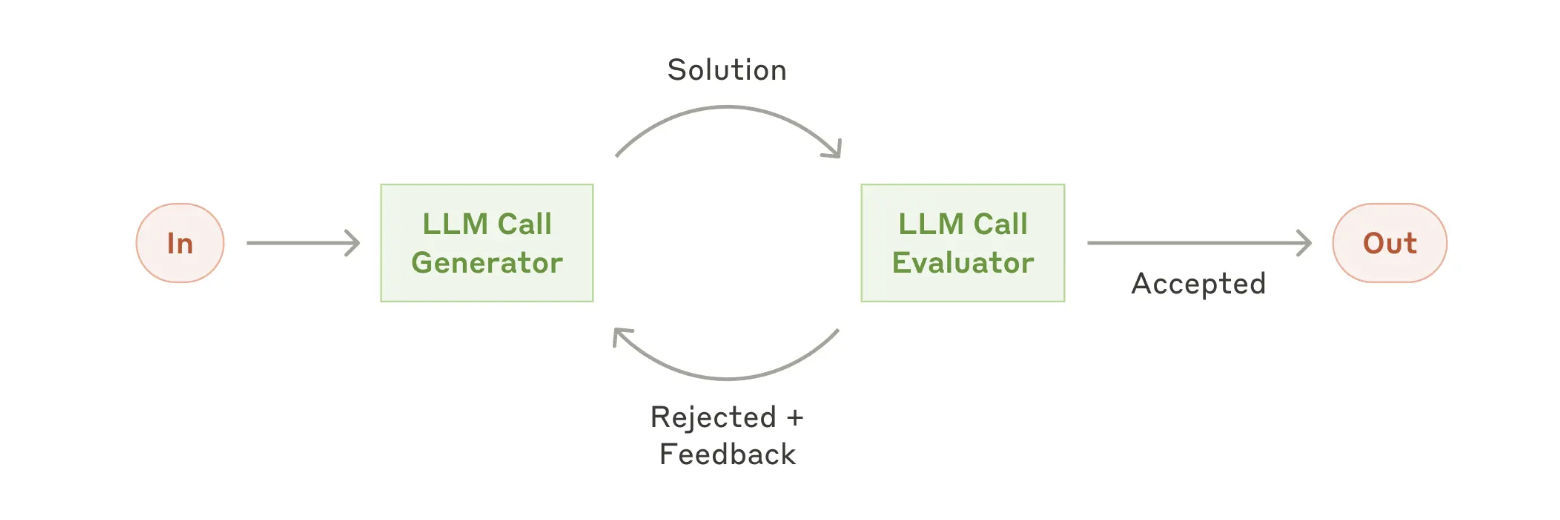



> 在这种 Workflow 中，一个 LLM call 生成响应，而另一个提供评估和反馈，形成一个闭环。



### 3.5.1 适用场景

**有明确的评估标准，并且迭代式改进确实有效（可衡量）。**

两个适用于此模式的标志，

- 当人类给出明确反馈时，LLM 响应可以明显改进；
- LLM 也能提供此类反馈。
- 类似于作家写一篇文章并不断润色的过程。

### 3.5.2 场景举例

- **文学翻译**

承担翻译任务的 LLM 可能没有捕捉到细微差别，但承担评估任务的 LLM 可以提供有用的批评。

- **复杂的搜索任务**

需要多轮搜索和分析以收集全面信息，评估者决定是否需要进一步搜索。

### 3.6 AI Workflow 小结

Workflow 是基于**增强型大模型**的一种应用形式，可以帮助用户将任务**分解为更小的子任务**，以便更好地处理。 虽然 Workflow 也有一些动态的能力，例如路由和并行化，但这种程度的动态能力还是**预定义的**。 下面将出场的 AI Agent，则在动态上与此完全不同了。

## 4 Agent



> 随着 LLM 在关键能力上的不断成熟 —— **理解复杂输入、进行推理和规划、可靠地使用工具以及自动从错误中恢复** —— 人们开始将 Agent 应用到生产环境中。



### 4.1 原理

Agent 一般从下面场景收到任务并开始执行：

- 收到明确的人类指令；
- 与人类交流到一定程度时，理解了自己接下来应该做什么。
- 一旦任务明确，Agent 就会独立规划和执行，中间也可能会问人类一些问题，以获取更多信息或帮助它自己做出正确判断。

在 Agent 执行过程中，对它来说**最重要的是每一步执行之后，都能从环境中获得“真实信息”（例如工具调用或执行代码），以帮助它评估任务的进展**。

Agent 可以**在检查点或遇到障碍时暂停，然后向人类获取帮助**。
任务通常在完成时**终止**，但也可以包括**停止条件**（例如最大迭代次数），以避免 Agent 行为不可控。

### 4.2 抽象层次：Agent vs. LLM

Agent 可以处理复杂的任务，但其实现通常很简单 —— 它们通常只是一些“**在一个循环中，基于环境反馈来选择合适的工具，最终完成其任务的大模型**”。 因此，**给 Agent 设计工具集时，其文档时必须清晰**，否则这些工具大模型用起来可能会效果欠佳。

### 4.3 何时使用 Agent

首先，必须对大模型的决策有一定程度的**信任**，否则就不要用 Agent 了。

其次，Agent 的自主性使它们非常适合在受信任的环境中执行任务。 Agent 的**自主性**质意味着**更高的成本**和**潜在的错误**累积。建议在沙箱环境中进行**广泛测试**，并设置适当的**保护措施**。

场景：难以或无法预测需要**多少步的开放式问题**，以及无法 hardcode 处理路径的情况。

### 4.4 Agent 设计三原则

在实现 Agent 时，建议遵循三个核心原则：

1. Agent 设计的**简洁性**。
2. Agent 工作过程的**透明性**，例如能明确显示 Agent 的规划和步骤。
3. 通过完善的文档和测试，精心设计 Agent 与计算机之间的**接口**（agent-computer interfaces, ACI）。

开源框架可以帮助你快速入门，但落地生产时，要**极力减少抽象层，尽量使用基本组件**。 遵循这些原则，就能创建出强大、可靠、可维护并受到用户信任的 Agent。

## 4.5 场景举例

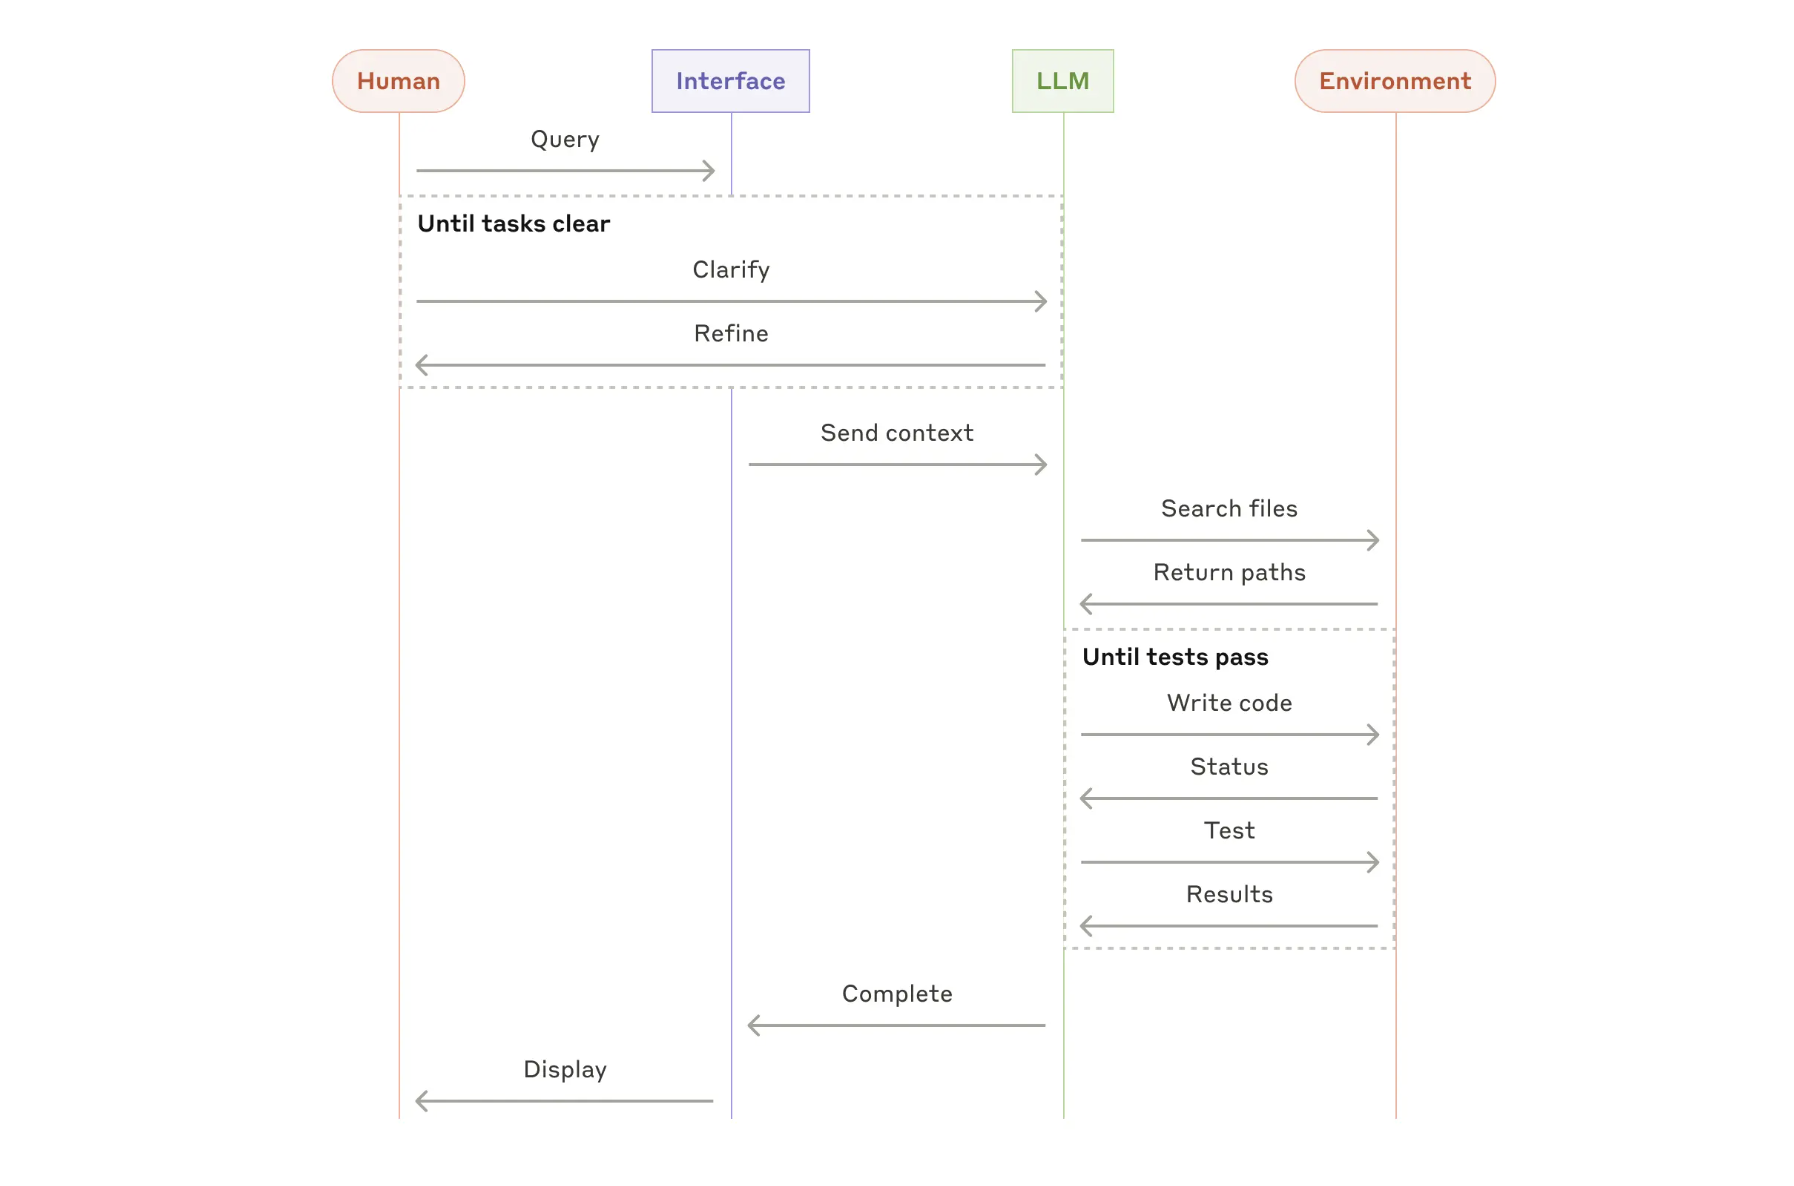

Anthropic自己的 Agent 例子：

一个解决 SWE-bench tasks 任务的 **Coding Agent**：会根据任务描述对多个文件进行编辑；

我们的 “computer use” reference implementation，其中 Claude 大模型使用计算机来完成任务。

## 5 总结

本文介绍的内容，不管是 Workflow 还是 Agent，**都是一种模式，而不是规范**， 开发者可以组合和改造这些模式来实现自己的 AI 系统。 成功的关键，是能衡量系统的性能，然后**不断对实现进行改进和迭代**。

大模型领域的成功**并不是构建最复杂的系统，而是构建符合你需求的系统**。 **从简单的提示词开始，不断评估和优化**，只有在简单的解决方案真的解决不了问题时，才应该考虑引入 multi-step agentic systems。 或者换句话说，**只有在性能有明显改善时，才应该考虑增加复杂性**。